## Data preparation and sanitization

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_categorical_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")
df = df.dropna()
## Usable columns: ['time_spent_risk', 'cells', 'selfish', 'time_spent_prop', 'count_effort', 
## 'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']
#df["effort"] = (1/df['time_spent_prop'] ) * (1/df['count_effort'])
# df_effort = df[['time_spent_prop', 'count_effort']]
# df_effort = (df_effort - df_effort.min()) / (df_effort.max() - df_effort.min())

# df['effort'] = df_effort['time_spent_prop'] * df_effort['count_effort']
# df = df[['time_spent_risk', 'cells', 'selfish', 'effort',
#          'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

# df = df[['selfish','Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

MAX_ACCEPTABLE_MIN_OFFER = 150
df = df[df['min_offer'] <= MAX_ACCEPTABLE_MIN_OFFER]

NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
MAX_GAIN = 200


#### Benchmark

In [3]:
from utils.benchmark import process_benchmarks, process_benchmark_cv, process_model


**Keras Model**

In [4]:
from models.deep import loss_tf, gain_tf, KerasModel

Using TensorFlow backend.


In [5]:
import os, sys


In [6]:
# #sci-kit like training
# sm = keras_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

**Featureless model (fixed value)**

In [7]:
from models import FeaturelessModel

**Convervative model**

In [8]:
from models import ConservativeModel

**Linear/Logistic regression**

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

**Random**

In [10]:
from models import RandomModel

**Random Forest**

In [11]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [12]:
from models import ClusterModel, ClusterExtModel

** Acceptance model **

In [13]:
from models import AcceptanceModel

** Data augmentation **

In [14]:
from utils.data_augmentation import DACombine

**Baseline models**

In [15]:
from sklearn.svm import SVC

benchmark_models = {
    #Featureless:
    #"random": RandomModel(MAX_GAIN),
    #"conservative": ConservativeModel(MAX_GAIN),
    "featureless": FeaturelessModel(MAX_GAIN),
    "svc": SVC(gamma='auto') 
#     "linear_regressor": LinearRegression(copy_X=False),
#     "linear_regressor_mse": keras_linear_regression(loss="mse"),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
featureless,27.137302,0.214675,24.181764,962.0,1526.091270,0.061905
svc,29.423016,0.238726,23.853842,1042.0,1774.662698,0.090476
featureless_da2,34.742063,0.276096,32.862134,1230.0,1978.988095,0.050476
svc_da2,78.215873,0.688895,24.018797,2770.0,8543.460317,0.632540


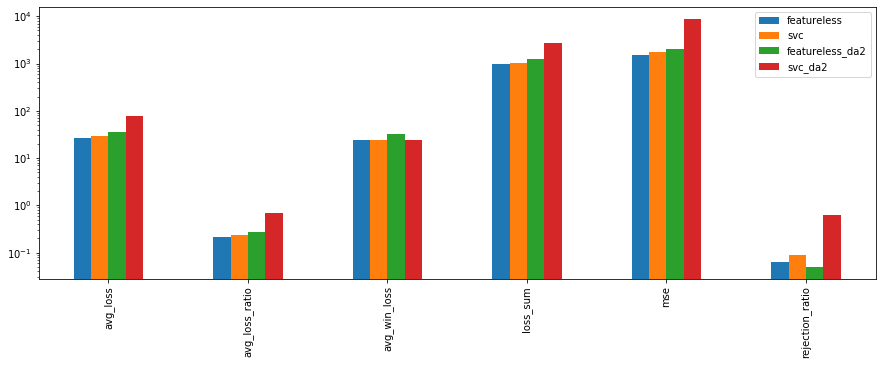

In [16]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [17]:
benchmark_models = {
#     #Cluster-based
    "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
}

results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
affinity,36.685873,0.305504,28.261474,1299.4,2408.801111,0.129841
meanshift,32.463492,0.256884,30.662134,1150.8,1777.513651,0.050476
affinity_ext,31.815079,0.268074,23.231686,1127.0,2064.797619,0.129683
meanshift_ext,27.137302,0.214675,24.181764,962.0,1526.091270,0.061905


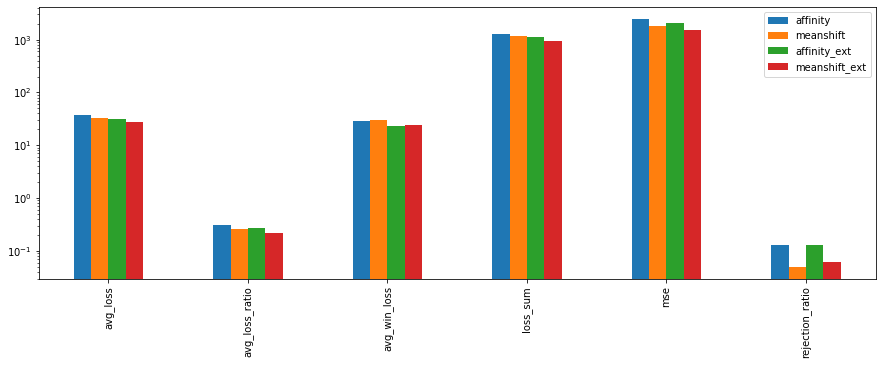

In [18]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [19]:
benchmark_models = {
    'featureless': FeaturelessModel(),
    # Regression
    "random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
#     "nn_regression_mse": keras_model(loss="mse"),
#     "nn_regression_ext": keras_model(loss=loss_tf),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    
    # Classification
    "random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/s

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
featureless,27.137302,0.214675,24.181764,962.000000,1526.091270,0.061905
random_forest_regr,67.783935,0.617674,22.331167,2399.490929,6643.874750,0.553651
logistic_regression,36.977778,0.323226,12.676321,1308.000000,3464.674603,0.259841
acceptance_model,35.513492,0.304167,25.295079,1258.000000,2368.202381,0.152063
random_forest,35.547619,0.303600,17.667236,1259.000000,2997.579365,0.209048
featureless_da2,46.513492,0.399822,34.444089,1642.000000,3289.559524,0.199048
random_forest_regr_da2,74.670022,0.659164,25.864953,2644.904698,7735.499531,0.587143
logistic_regression_da2,73.775397,0.647436,24.106303,2613.000000,7850.742063,0.575873
acceptance_model_da2,42.718254,0.369185,30.108383,1514.000000,3079.980159,0.185556
random_forest_da2,78.873810,0.689916,30.714752,2792.000000,8379.107143,0.604444


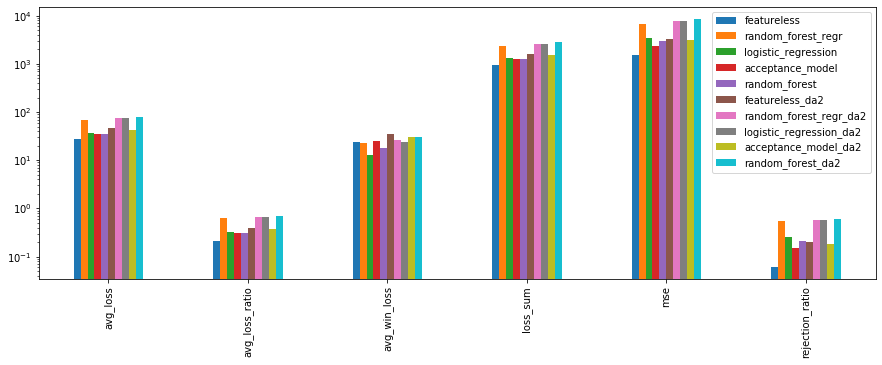

In [20]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**TOP MODELS**

In [21]:
benchmark_models = {
    'featureless': FeaturelessModel(),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    'svc': SVC(gamma='auto'),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None, shuffle=True)
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
featureless,27.209524,0.215429,24.197321,962.0,1532.150794,0.062540
logistic_regression,38.028571,0.331315,15.212579,1345.0,3419.404762,0.254921
svc,27.780952,0.226150,23.264132,982.0,1577.865079,0.079683
acceptance_model,34.546032,0.294154,26.436890,1222.0,2181.658730,0.130317


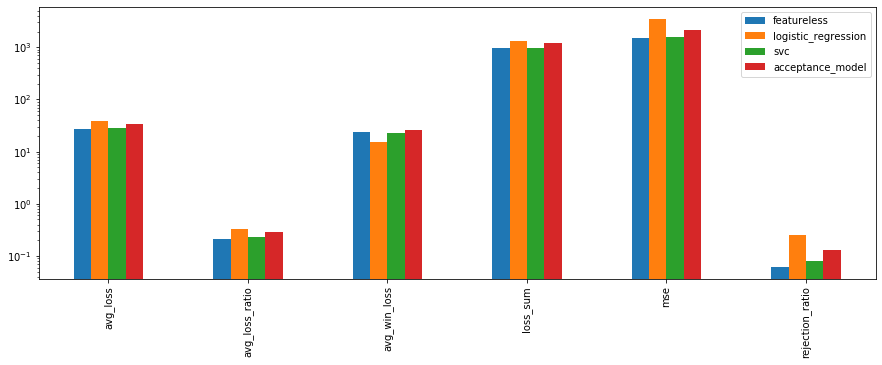

In [22]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))